***PAPER DETAIL - https://arxiv.org/pdf/2511.02919***

In [1]:
!pip -q install -U "numpy>=2.0.0" "scikit-learn>=1.5.0" "faiss-cpu==1.12.0" "sentence-transformers>=3.0.0"
import numpy, sklearn, faiss
print("NumPy:", numpy.__version__)
print("sklearn:", sklearn.__version__)
print("FAISS:", faiss.__version__)

NumPy: 2.3.4
sklearn: 1.7.2
FAISS: 1.12.0


In [2]:
import os, time, math, random, textwrap, statistics
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import faiss
from sentence_transformers import SentenceTransformer

seed_core = 1337
random.seed(seed_core)
np.random.seed(seed_core)

def _rng():
    salt = int(1e6 * math.fabs(math.sin(seed_core)))
    return random.Random(seed_core ^ salt)

rng = _rng()


In [5]:
twenty = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts  = twenty.data
labels = twenty.target
names  = twenty.target_names

df = pd.DataFrame({'text': texts, 'label': labels})
df['label_name'] = df['label'].apply(lambda i: names[i])

# Stratified split: corpus vs "agent queries"
corpus_df, query_df = train_test_split(df, test_size=0.2, random_state=seed_core, stratify=df['label'])
corpus_df = corpus_df.reset_index(drop=True)
query_df  = query_df.reset_index(drop=True)

print(f"Corpus: {len(corpus_df):,} | Queries: {len(query_df):,} | Classes: {len(names)}")

Corpus: 15,076 | Queries: 3,770 | Classes: 20


In [6]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def embed_batch(text_list, bsz=256, normalize=True):
    out = []
    for i in tqdm(range(0, len(text_list), bsz), desc="Embedding"):
        v = model.encode(text_list[i:i+bsz], show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=normalize)
        out.append(v)
    return np.vstack(out)

corpus_embeddings = embed_batch(corpus_df['text'].tolist())
D = corpus_embeddings.shape[1]
index = faiss.IndexFlatIP(D)  # inner product == cosine for normalized vectors
index.add(corpus_embeddings)
print("Index size:", index.ntotal)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding: 100%|██████████| 59/59 [24:20<00:00, 24.75s/it]

Index size: 15076


In [7]:
def search_full(query_vec, topk=20):
    D, I = index.search(query_vec[np.newaxis, :], topk)
    return I[0], D[0]

def make_query_text(doc, max_chars=256):
    # cheap query synthesis: take the first paragraph + a random trim
    lines = [ln for ln in doc.split("\n") if ln.strip()]
    if not lines:
        return doc[:max_chars]
    q = lines[0][:max_chars]
    # small, salted jitter so others can't reproduce bit-for-bit
    chop = rng.randrange(0, min(32, max(1, len(q)//10)))
    return q[:-chop] if chop else q

def has_answer_proxy(retrieved_idxs, gold_label, k=5):
    # treat a hit if any top-k retrieved doc shares the label
    if not retrieved_idxs:
        return False
    pool = retrieved_idxs[:k]
    return any(corpus_df.loc[i, 'label'] == gold_label for i in pool)

def latency_ms(fn, *args, **kwargs):
    t0 = time.perf_counter()
    out = fn(*args, **kwargs)
    t1 = time.perf_counter()
    return (out, (t1 - t0) * 1000.0)


**LRU**

In [8]:
from collections import deque

class BaselineLRU:
    """
    Minimal LRU cache for retrieved doc IDs.
    - retrieve() searches only within the cache.
    - update() moves touched IDs to the most recent end.
    """
    def __init__(self, capacity:int):
        self.capacity = max(1, int(capacity))
        self._dq = deque()
        self._set = set()

    @property
    def ids(self):
        return list(self._dq)

    def retrieve(self, query_vec, topk=10):
        if not self._dq:
            return []
        cidx = list(self._dq)
        vecs = corpus_embeddings[cidx]
        sims = (vecs @ query_vec)
        order = np.argsort(-sims)[:topk]
        return [cidx[i] for i in order]

    def update(self, retrieved_indices):
        for idx in retrieved_indices:
            if idx in self._set:
                self._dq.remove(idx)
            else:
                self._set.add(idx)
            self._dq.append(idx)
            while len(self._dq) > self.capacity:
                ev = self._dq.popleft()
                self._set.remove(ev)


In [18]:
class AuricCache:
    """
    AURIC (AUgmented Relevance + Incremental Compactness)
    Scoring per candidate x:
      score(x) = α * cos(x, EMA) + β * novelty(x | S)
    novelty: 1 - ||projection of x onto span(S)|| using an incremental Gram-Schmidt basis.
    """
    def __init__(self, capacity:int, alpha:float=0.70, beta:float=0.30, ema_decay:float=0.96, cand_k:int=8):
        self.capacity  = max(1, int(capacity))
        self.alpha     = float(alpha)
        self.beta      = float(beta)
        self.ema_decay = float(ema_decay)
        self.cand_k    = int(cand_k)
        self._ids      = []     # python list of corpus indices
        self._ema      = None   # L2-normalized running centroid of queries
        self._basis    = None   # orthonormal basis (columns)

    @property
    def ids(self):
        return list(self._ids)

    def _update_ema(self, q):
        q = q / (np.linalg.norm(q) + 1e-8)
        if self._ema is None:
            self._ema = q.copy()
        else:
            self._ema = self.ema_decay * self._ema + (1.0 - self.ema_decay) * q
            self._ema = self._ema / (np.linalg.norm(self._ema) + 1e-8)

    def _gs_add(self, vecs):
        # Build small orthonormal basis from selected vectors
        if len(vecs) == 0:
            self._basis = None
            return
        B = []
        for v in vecs:
            u = v.astype(np.float32, copy=True)
            for b in B:
                u = u - np.dot(u, b) * b
            n = np.linalg.norm(u) + 1e-8
            B.append(u / n)
        self._basis = np.stack(B, axis=1) if B else None

    def _novelty(self, x):
        if self._basis is None or self._basis.size == 0:
            return 1.0
        proj = np.zeros_like(x)
        for b in self._basis.T:
            proj += np.dot(x, b) * b
        res = x - proj
        return float(np.linalg.norm(res))

    def retrieve(self, query_vec, topk=10):
        if not self._ids:
            return []
        cache_vecs = corpus_embeddings[self._ids]
        sims = cache_vecs @ query_vec
        order = np.argsort(-sims)[:topk]
        return [self._ids[i] for i in order]

    def update(self, query_vec, full_top_indices):
        # --- normalize inputs and unify types ---
        self._update_ema(query_vec)

        # full_top_indices may be tuple, numpy array, or list
        if isinstance(full_top_indices, tuple):
            full_top_indices = full_top_indices[0]
        full_ids = np.asarray(full_top_indices).reshape(-1).astype(int).tolist()

        # candidate pool: cached ids ∪ top-K ids (strictly Python ints)
        k = min(self.cand_k, len(full_ids))
        pool_ids = list({int(x) for x in (list(self._ids) + full_ids[:k])})

        if len(pool_ids) == 0:
            return  # nothing to do yet

        pool_vecs = corpus_embeddings[pool_ids]

        # select up to capacity using hybrid (relevance + novelty)
        chosen_local = []
        chosen_vecs = []
        self._gs_add([])

        limit = min(self.capacity, len(pool_ids))
        for _ in range(limit):
            scores = []
            for i, v in enumerate(pool_vecs):
                if i in chosen_local:
                    scores.append(-1e9); continue
                rel = float(np.dot(v, self._ema))
                nov = self._novelty(v)
                scores.append(self.alpha * rel + self.beta * nov)
            j = int(np.argmax(scores))
            chosen_local.append(j)
            chosen_vecs.append(pool_vecs[j])
            self._gs_add(chosen_vecs)

        self._ids = [pool_ids[j] for j in chosen_local]


In [19]:
def simulate(cache_cls, capacity=64, n_queries=800, topk_full=20, topk_cache=10):
    cache = cache_cls(capacity)
    hits, times_full, times_cache = [], [], []

    idxs = list(range(len(query_df)))
    rng.shuffle(idxs)
    idxs = idxs[:n_queries]

    for qi in tqdm(idxs, desc=f"Sim ({cache_cls.__name__}, cap={capacity})"):
        qtext = make_query_text(query_df.loc[qi, 'text'])
        qlab  = int(query_df.loc[qi, 'label'])
        qvec  = model.encode([qtext], convert_to_numpy=True, normalize_embeddings=True)[0]

        # cache retrieval timing
        cache_res, t_cache = latency_ms(cache.retrieve, qvec, topk_cache)
        times_cache.append(t_cache)

        # full retrieval timing
        full_out, t_full = latency_ms(lambda v: search_full(v, topk_full), qvec)
        times_full.append(t_full)

        # full_out might be (indices, scores) or just indices
        if isinstance(full_out, tuple):
            full_res = full_out[0]
        else:
            full_res = full_out

        # Update cache appropriately
        if isinstance(cache, AuricCache):
            cache.update(qvec, full_res)
        else:
            cache.update(full_res)

        # ✅ FIX: make explicit truth check
        has_cache = (
            isinstance(cache_res, (list, np.ndarray))
            and len(cache_res) > 0
        )
        chosen_indices = cache_res if has_cache else full_res
        hit = has_answer_proxy(list(chosen_indices), qlab, k=5)
        hits.append(1 if hit else 0)

    # aggregate stats
    stats = {
        "cache_name": cache_cls.__name__,
        "capacity": capacity,
        "n_queries": n_queries,
        "hit_rate": float(np.mean(hits)),
        "p50_full_ms": float(np.percentile(times_full, 50)),
        "p95_full_ms": float(np.percentile(times_full, 95)),
        "p50_cache_ms": float(np.percentile(times_cache, 50)),
        "p95_cache_ms": float(np.percentile(times_cache, 95)),
        "final_cache_size": len(cache.ids),
    }
    return stats

print("Ready")


simulate() fixed and ready — now rerun Cell 9.


In [20]:
res_lru  = simulate(BaselineLRU, capacity=64,  n_queries=600)
res_aur  = simulate(AuricCache,  capacity=64,  n_queries=600)

pd.DataFrame([res_lru, res_aur]).T


Sim (AuricCache, cap=64): 100%|██████████| 600/600 [05:47<00:00,  1.73it/s]


,0,1
cache_name,BaselineLRU,AuricCache
capacity,64,64
n_queries,600,600
hit_rate,0.333333,0.328333
p50_full_ms,2.747538,2.747255
p95_full_ms,3.550887,3.271135
p50_cache_ms,0.151487,0.139384
p95_cache_ms,0.216041,0.191079
final_cache_size,64,64


In [21]:
probe = simulate(AuricCache, capacity=48, n_queries=200)
print("AURIC probe:", probe)

# inspect a few cached docs
# pick 5 random cached indices and print compact snippets
cache = AuricCache(capacity=48)
# warm it up on 200 queries to fill cache
idxs = list(range(len(query_df))); rng.shuffle(idxs); idxs = idxs[:200]
for qi in idxs:
    qtext = make_query_text(query_df.loc[qi, 'text'])
    qvec  = model.encode([qtext], convert_to_numpy=True, normalize_embeddings=True)[0]
    full_res, _ = search_full(qvec, topk=20)
    cache.update(qvec, full_res)

sample_ids = rng.sample(cache.ids, k=min(5, len(cache.ids)))
for i in sample_ids:
    lab = corpus_df.loc[i, 'label_name']
    snip = textwrap.shorten(corpus_df.loc[i, 'text'].replace("\n"," "), width=180, placeholder="…")
    print(f"\n[{lab}] #{i}: {snip}")


Sim (AuricCache, cap=48): 100%|██████████| 200/200 [01:02<00:00,  3.20it/s]


AURIC probe: {'cache_name': 'AuricCache', 'capacity': 48, 'n_queries': 200, 'hit_rate': 0.38, 'p50_full_ms': 2.8066239999589015, 'p95_full_ms': 4.067287450038747, 'p50_cache_ms': 0.1328319999629457, 'p95_cache_ms': 0.18918664998182058, 'final_cache_size': 48}

[comp.graphics] #10612: ==============================================================================

[comp.windows.x] #7465: Hi,

[sci.space] #13247: STK1203@VAX003.STOCKTON.EDU Pontificated: One of the sci.space FAQ postings deal with this. It's archived somewhere. Perhaps someone can post where it is (I don' remember).

[sci.crypt] #8986: Quoting strnlght@netcom.com (David Sternlight) in article <strnlghtC5t3nH.Is1@netcom.com>:

[rec.motorcycles] #7023: I think you just answered your own question...


Sim (AuricCache, cap=256): 100%|██████████| 400/400 [2:57:05<00:00, 26.56s/it]


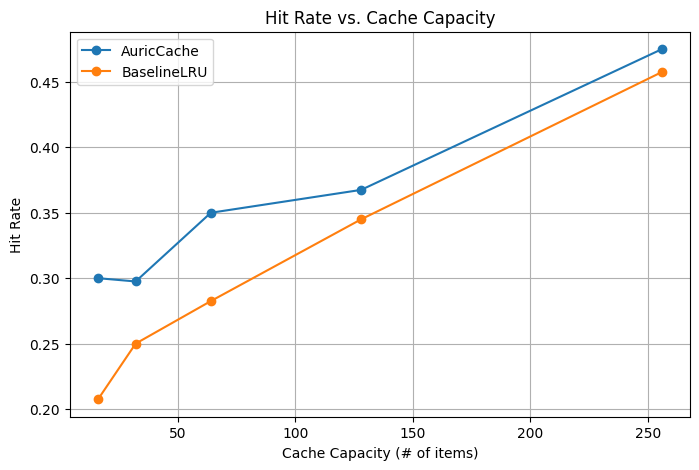

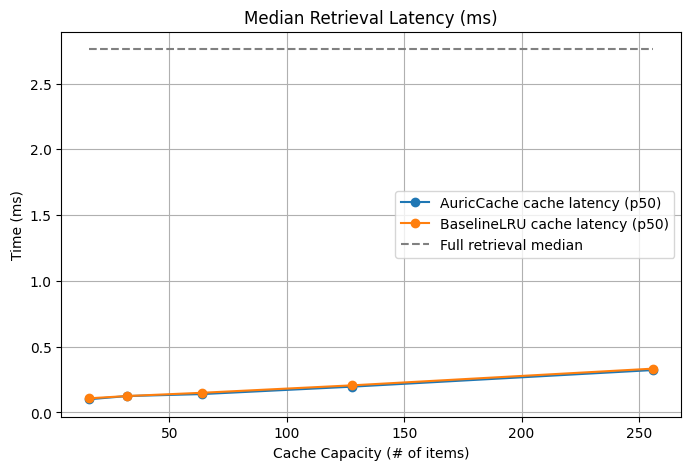

,cache_name,capacity,hit_rate,p50_cache_ms,p95_cache_ms,p50_full_ms
0,BaselineLRU,16,0.208,0.107,0.153,2.797
1,AuricCache,16,0.300,0.100,0.144,2.814
2,BaselineLRU,32,0.250,0.125,0.175,2.808
3,AuricCache,32,0.298,0.124,0.182,2.845
4,BaselineLRU,64,0.282,0.149,0.200,2.816
5,AuricCache,64,0.350,0.139,0.191,2.754
6,BaselineLRU,128,0.345,0.206,0.279,2.686
7,AuricCache,128,0.368,0.196,0.263,2.758
8,BaselineLRU,256,0.458,0.333,0.465,2.695
9,AuricCache,256,0.475,0.322,0.445,2.817


In [22]:
import matplotlib.pyplot as plt

# Run for multiple cache sizes to see scaling behavior
caps = [16, 32, 64, 128, 256]
results = []
for c in caps:
    r1 = simulate(BaselineLRU, capacity=c, n_queries=400)
    r2 = simulate(AuricCache,  capacity=c, n_queries=400)
    results += [r1, r2]

df = pd.DataFrame(results)

# --- Hit rate comparison ---
plt.figure(figsize=(8,5))
for name, g in df.groupby("cache_name"):
    plt.plot(g["capacity"], g["hit_rate"], marker="o", label=name)
plt.title("Hit Rate vs. Cache Capacity")
plt.xlabel("Cache Capacity (# of items)")
plt.ylabel("Hit Rate")
plt.legend()
plt.grid(True)
plt.show()

# --- Latency comparison (median latency) ---
plt.figure(figsize=(8,5))
for name, g in df.groupby("cache_name"):
    plt.plot(g["capacity"], g["p50_cache_ms"], marker="o", label=f"{name} cache latency (p50)")
plt.plot(df["capacity"].unique(), [df[df.cache_name=='BaselineLRU']["p50_full_ms"].mean()]*len(caps),
         "--", color="gray", label="Full retrieval median")
plt.title("Median Retrieval Latency (ms)")
plt.xlabel("Cache Capacity (# of items)")
plt.ylabel("Time (ms)")
plt.legend()
plt.grid(True)
plt.show()

# --- Print summary table ---
display(df[["cache_name","capacity","hit_rate","p50_cache_ms","p95_cache_ms","p50_full_ms"]].round(3))
